In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
import src.utils_contributions as utils_contributions
from src.contributions import ModelWrapper
from extract_explanations import read_blimp_dataset, tokens2words, track2input_tokens, read_sva_dataset, read_ioi_dataset
import pandas as pd
from lm_saliency import *
import pickle
import os
#torch.cuda.set_device(1)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
# Currently works for:
#  OPT: facebook/opt-125m
#  GPT-Neo: EleutherAI/gpt-neo-125M, EleutherAI/gpt-neo-2.7B
#  GPT-2: gpt2 (124M), gpt2-large (774M), gpt2-xl (1.5B)
# bigscience/bloom-560m
name_path = 'gpt2'
model, tokenizer = utils_contributions.load_model_tokenizer(name_path)
# Get number of layers in model
try:
    num_layers = model.config.n_layers
except:
    num_layers = model.config.num_hidden_layers

model_wrapped = ModelWrapper(model)

In [4]:
def l_transform(x, w_ln, ln_eps, pre_ln_states):
    '''Computes mean and performs hadamard product with ln weight (w_ln) as a linear transformation.
        Also divides by the SD of the input vector.
    '''
    ln_param_transf = torch.diag(w_ln)
    ln_mean_transf = torch.eye(w_ln.size(0)).to(w_ln.device) - \
        1 / w_ln.size(0) * torch.ones_like(ln_param_transf).to(w_ln.device)

    ln_std_coef = 1/(pre_ln_states + ln_eps).std(-1)#.view(1,-1,1)
    ln_mean_transf = ln_mean_transf

    out = torch.einsum(
        '... e , e f , f g -> ... g',
        x,
        ln_mean_transf,
        ln_param_transf
    )
    
    return out*(ln_std_coef.view(1, -1, 1, 1))

In [5]:
dataset = 'blimp'

In [6]:
def compute_mlp_values_logit_diff(model_wrapped, CORRECT_ID,FOIL_ID):
    logits_diff_values_unembedding = []

    for layer in range(num_layers):
        x_ = model_wrapped.func_inputs['transformer.h.' + str(layer) + '.mlp.c_proj'][0][0]
        values = model_wrapped.model.transformer.h[layer].mlp.c_proj.weight

        output_pos = -1
        lnf_weight = model_wrapped.model.transformer.ln_f.weight.data.detach()
        lnf_eps = model_wrapped.model.transformer.ln_f.eps
        lnf_bias = model_wrapped.model.transformer.ln_f.bias
        pre_lnf_states = model_wrapped.func_inputs['transformer.ln_f'][0][0]

        unembedding = model_wrapped.model.lm_head.weight[[CORRECT_ID,FOIL_ID]]

        weighted_values = torch.einsum(
            "b t m , m d -> b t m d",
            x_,
            values,
        )

        l_weighted_values = l_transform(weighted_values, lnf_weight, lnf_eps, pre_lnf_states[output_pos])
        logits_ffn = torch.einsum(
            "b t m d , v d -> b t m v",
            l_weighted_values,
            unembedding
        )

        logits_diff = logits_ffn[0, -1, :, 0] - logits_ffn[0, -1, :, 1]
        logits_diff_values_unembedding.append(logits_diff.data.detach().cpu().numpy())

    return logits_diff_values_unembedding

    

In [183]:
dataset = 'sva_4' # determiner_noun_agreement_1

In [184]:
if 'sva' in dataset:
    df = read_sva_dataset()
    num_attractors = int(dataset[-1])
    if num_attractors != -1:
        df = df[df['num_attractors']==num_attractors].reset_index(drop=True)
    num_examples = 200

elif dataset == 'ioi':
    df = read_ioi_dataset()
    num_examples = len(df)
else:
    df = read_blimp_dataset(dataset)
    num_examples = len(df)

In [185]:
from tqdm import tqdm


logits_diff_values_unembedding_dataset = []

for idx in tqdm(range(num_examples)):

    if 'sva' in dataset:
        text = df['one_prefix_prefix'][idx][:df['one_prefix_prefix'][idx].index('***mask***')-1]
    else:
        text = df['one_prefix_prefix'][idx]

    target = df['one_prefix_word_good'][idx]
    foil = df['one_prefix_word_bad'][idx]

    input = text

    if dataset != 'manual':
        target = df['one_prefix_word_good'][idx]
        foil = df['one_prefix_word_bad'][idx]

    if 'facebook/opt' in tokenizer.name_or_path:
        # OPT tokenizer adds a BOS token at pos 0
        CORRECT_ID = tokenizer(" "+ target)['input_ids'][1]
        FOIL_ID = tokenizer(" "+ foil)['input_ids'][1]
    else:
        CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
        FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]

    # if CORRECT_ID == FOIL_ID:
    #     logits_diff_values_unembedding_dataset.append()

    pt_batch = tokenizer(text, return_tensors="pt").to(device)
    input_ids = pt_batch['input_ids']
    tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
    logits, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)

    logits_diff_values_unembedding = compute_mlp_values_logit_diff(model_wrapped, CORRECT_ID, FOIL_ID)
    logits_diff_values_unembedding_dataset.append(logits_diff_values_unembedding)

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:24<00:00,  2.35it/s]


In [186]:
len(logits_diff_values_unembedding_dataset)

200

In [187]:

os.makedirs(f'./results/logits_ffn', exist_ok = True)
with open(f'./results/logits_ffn/{dataset}_{name_path}.pickle', 'wb') as handle:
    pickle.dump(logits_diff_values_unembedding_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
dataset = 'sva_4'#determiner_noun_agreement_1

In [48]:
# Read pickle file with logits information
with open(f'./results/logits_ffn/{dataset}_{name_path}.pickle', 'rb') as handle:
    logits_ffn_file = pickle.load(handle)

# Read pickle file with logits information
with open(f'./results/logits/{dataset}_{name_path}.pickle', 'rb') as handle:
    logits_file = pickle.load(handle)

In [49]:
# Read sentence of dataset
#df_sentence = pd.read_csv(f'./data/blimp_with_targets/{dataset}.csv')['sentence_good']
if 'sva' in dataset:
    df = read_sva_dataset()
    num_attractors = int(dataset[-1])
    if num_attractors != -1:
        df = df[df['num_attractors']==num_attractors].reset_index(drop=True)
    num_examples = 200
    df = df.iloc[:num_examples]
    df_sentence = df['sentence_good']

elif dataset == 'ioi':
    df = read_ioi_dataset()
    num_examples = len(df)
    df_sentence = df['Sentence_good']
else:
    df = read_blimp_dataset(dataset)
    num_examples = len(df)
    df_sentence = df['sentence_good']

df_acceptable = df['one_prefix_word_good']

In [50]:
total_logit_diff_list = []
for idx in range(num_examples):
    if logits_file[idx] == 'NA':
        total_logit_diff_list.append(0)
    else:
        total_logit_diff_list.append(logits_file[idx]['correct_id_logit'] - logits_file[idx]['foil_id_logit'])
total_logit_diff_np = np.array(total_logit_diff_list)

In [51]:
apply_filter = True

In [52]:

if apply_filter:
    #index_filter = list(df_sentence[df_sentence.str.contains('this|that')].index)
    #index_filter = list(df_sentence[df_sentence.str.contains('these|those')].index)
    index_filter = list(df_sentence[df_acceptable.str.endswith('s')|df_acceptable.str.contains('has|does')].index)
    #index_filter = list(df_sentence[df_acceptable.str.contains("hasn't|doesn't")].index)
    total_logit_diff_np = total_logit_diff_np[index_filter]

if apply_filter:
    logits_ffn_file_np = np.array(logits_ffn_file)[index_filter]
else:
    logits_ffn_file_np = np.array(logits_ffn_file)
logits_ffn_file_np.shape


(16, 12, 3072)

In [53]:
total_logit_diff_np_no_zeros = total_logit_diff_np[total_logit_diff_np != 0]

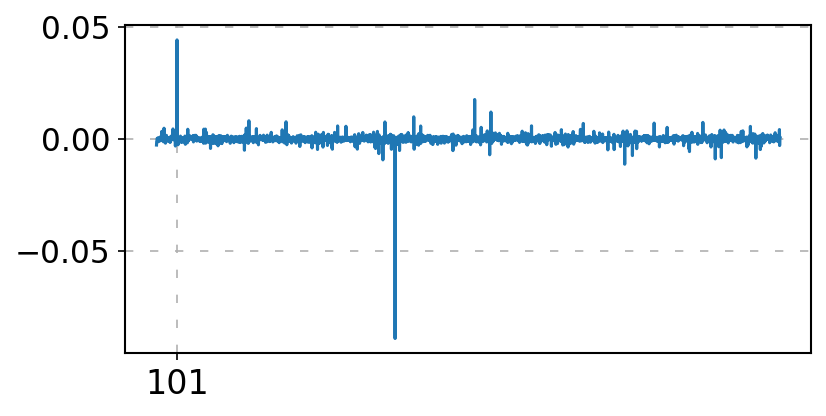

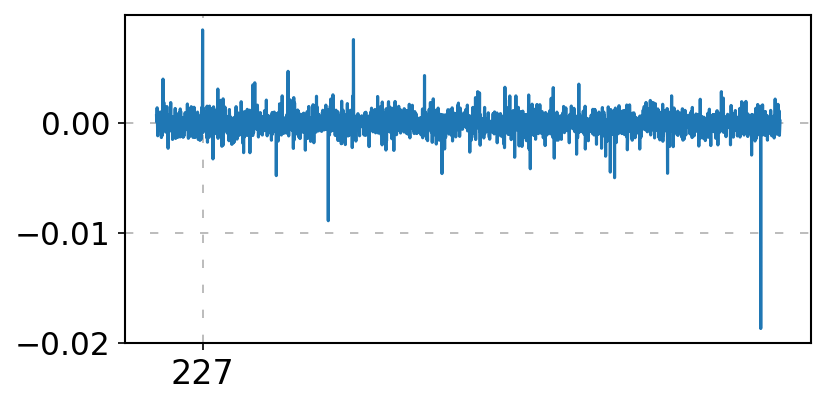

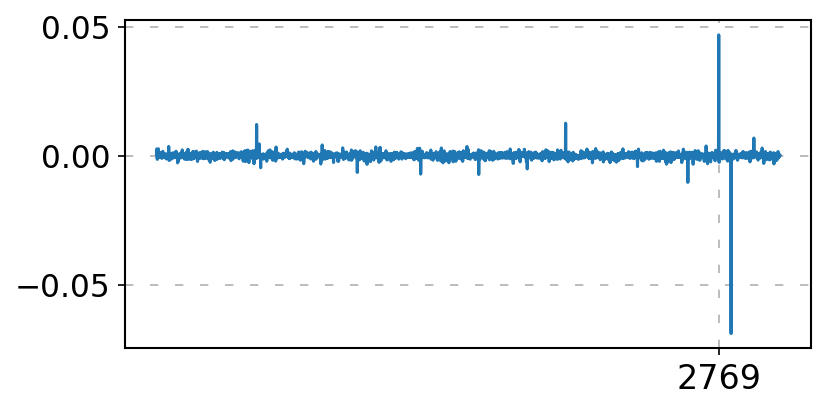

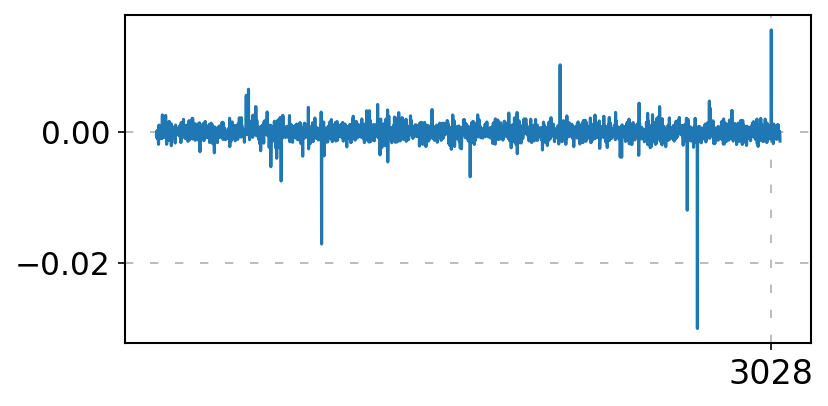

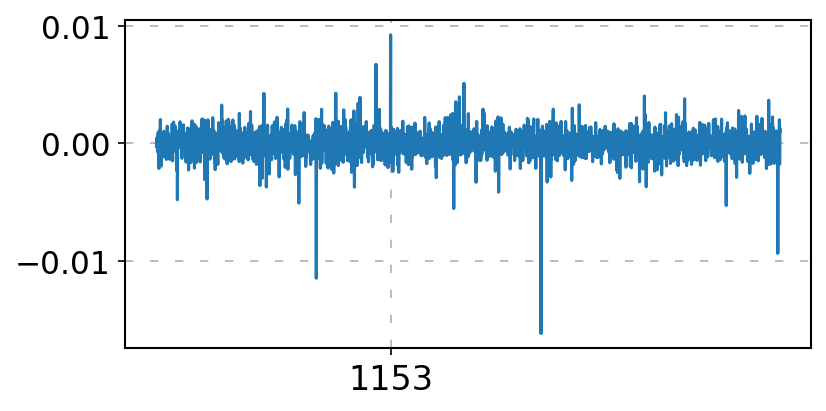

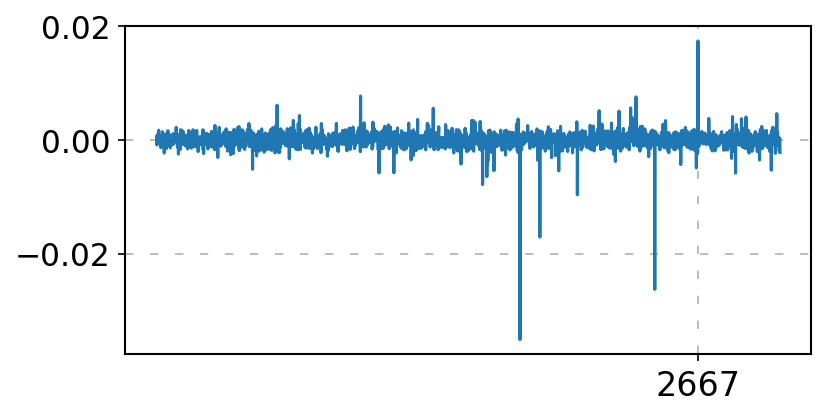

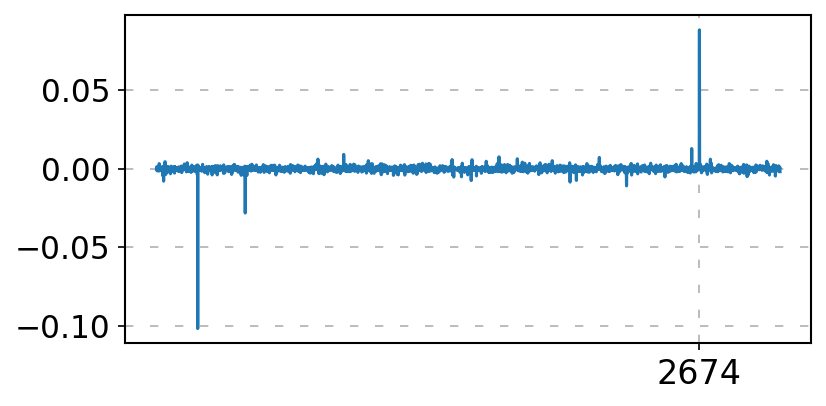

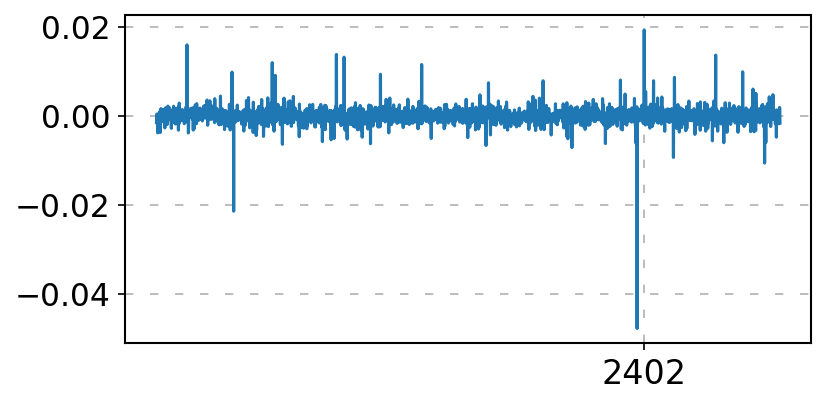

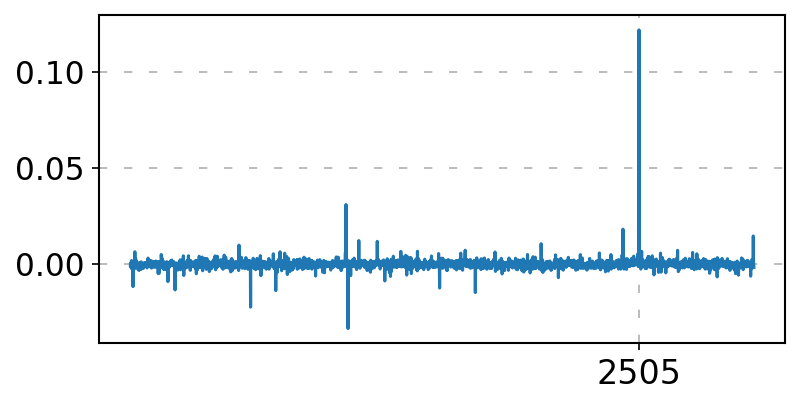

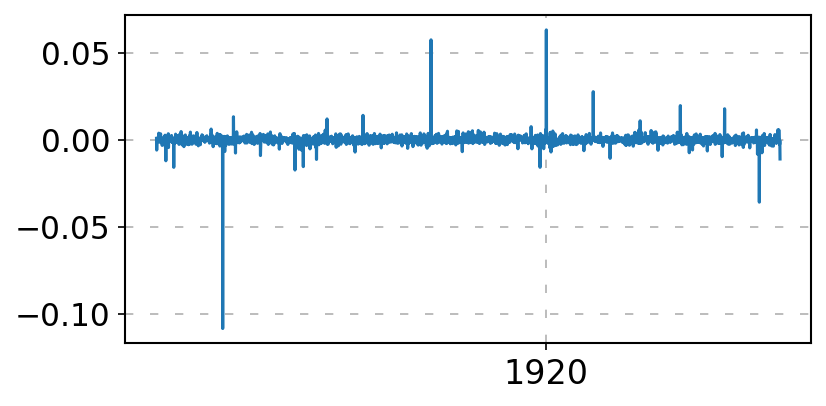

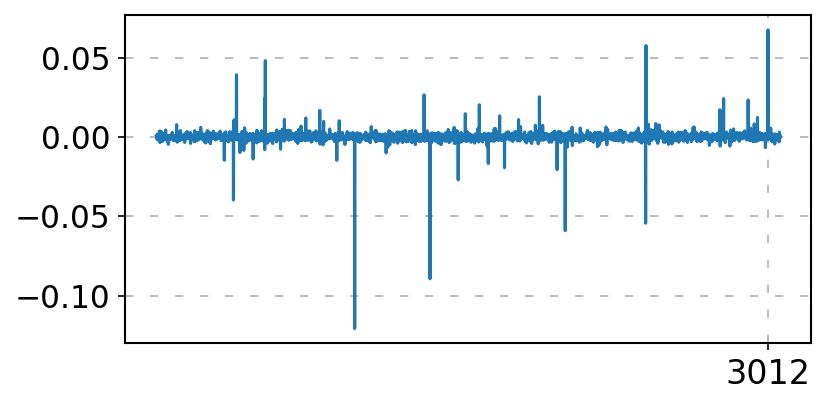

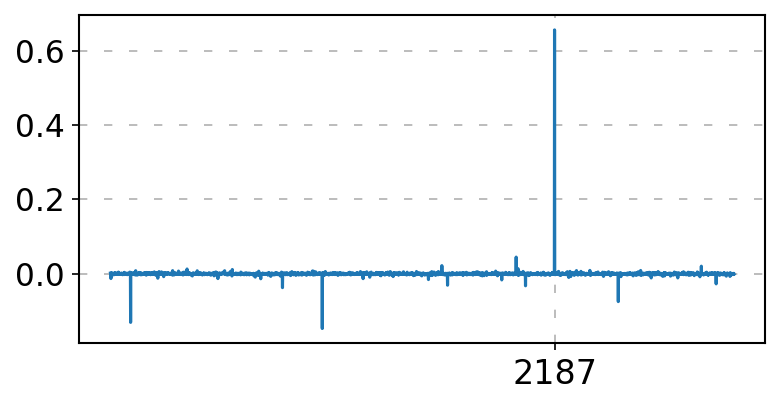

In [54]:
for layer in range(0,num_layers):
    logits_diff_layer_proportion = logits_ffn_file_np[total_logit_diff_np != 0][:,layer,:]#/(np.expand_dims(total_logit_diff_np_no_zeros, axis=-1))
    logits_diff_layer_mean = np.array(logits_diff_layer_proportion.mean(0))
    fig, ax = plt.subplots(figsize =(5.9, 2.9),dpi=150)

    plt.plot(logits_diff_layer_mean)
    ax.set_xticks([logits_diff_layer_mean.argmax()])
    ax.set_xticklabels([logits_diff_layer_mean.argmax()], size=16)

    #ax.set_ylabel(r'$\Delta \mathrm{logit}_{(w-f)}$')
    ax.grid(True, linestyle=(0, (5, 10)));

In [21]:
print('max', torch.tensor(logits_diff_layer_mean).topk(k=10).indices)
print('min', torch.tensor(logits_diff_layer_mean).topk(k=10, largest=False).indices)

max tensor([2187, 1043,  627, 1632, 1660,  529, 1331, 1998, 2049, 1512])
min tensor([2794,   99, 3051, 2501, 2983, 2267,  847,  645,  524, 2492])


In [43]:
for layer in range(1):
    logits_ffn_layer = np.array(logits_ffn_file)[:,layer,:].transpose()
    corr_matrix = np.corrcoef(logits_ffn_layer, total_logit_diff_np)[-1,:-1]
    corr_matrix.shape


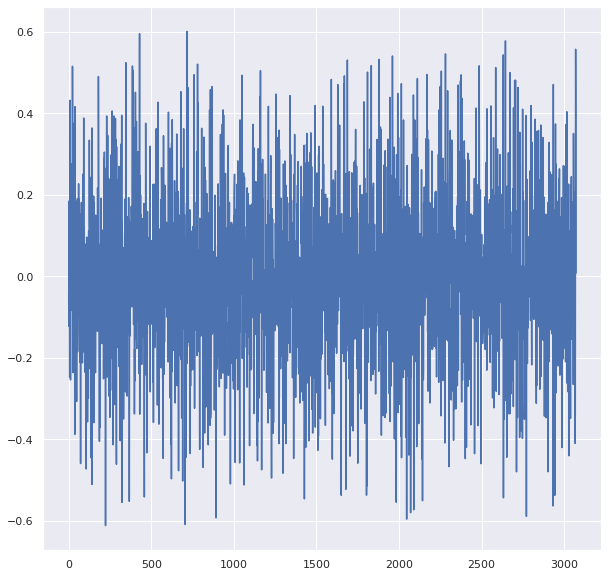

In [324]:
plt.plot(corr_matrix)
